------------------------------------------------------------
MODEL RUN (best guess parameters, no calibration)
R_eff_m     = 60,000 m
h_eff_m     = 4.00 m
Tr_hours    = 4.00 h
axis_to_deg = 135.0 deg (TO)
------------------------------------------------------------
eta_proxy_m summary (m):
count    5.600340e+05
mean     7.607805e-03
std      2.580217e-02
min     -3.282325e-01
50%      1.602362e-10
90%      2.121910e-02
99%      1.243148e-01
max      1.631990e+00
Name: eta_proxy_m, dtype: float64
------------------------------------------------------------


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_5124\2815148885.py:138: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  eta_all = wind2["eta_proxy_m"].resample(rule).max()
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_5124\2815148885.py:139: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  eta_nw  = wind2["eta_proxy_m"].where(wind2["is_NW"]).resample(rule).max()


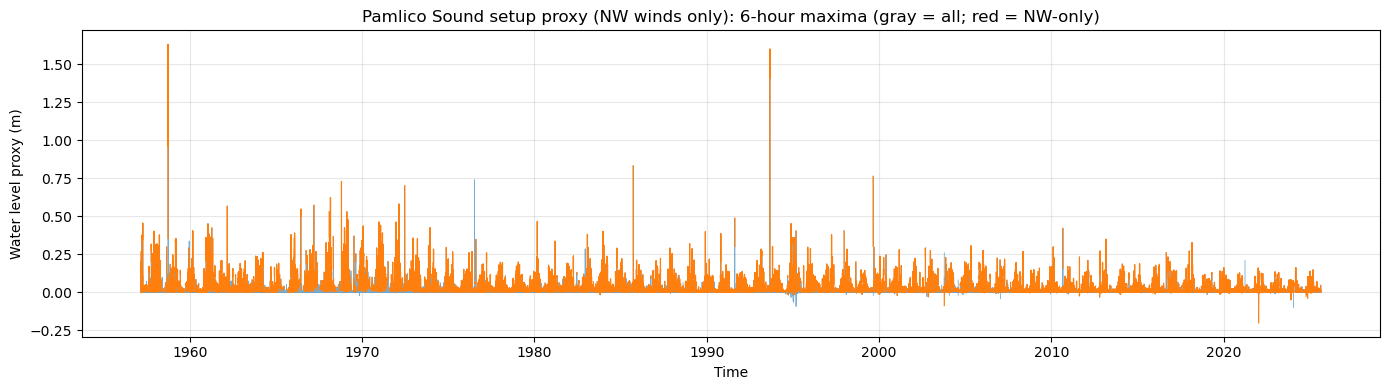

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# USER SETTINGS
# ============================================================
# KHSE merged winds (from your earlier workflow)
WIND_CSV = "isd_KHSE_only/KHSE_area_ISD_wind_merged.csv"  # <-- change if needed

# NW-only definition (met direction FROM, degrees)
NW_DIR_MIN = 270.0
NW_DIR_MAX = 360.0

# "Best guess" Pamlico Sound proxy parameters (no calibration)
R_eff_m      = 60_000.0   # effective radius (m)
h_eff_m      = 4.0        # effective depth (m)
Tr_hours     = 4.0        # response time (hours)
axis_to_deg  = 135.0      # direction TO that raises water at the point (deg)

# Plot decimation (max over bins) just to keep the full-record plot readable
PLOT_BIN_HOURS = 6

# ============================================================
# CONSTANTS
# ============================================================
RHO_AIR = 1.22
RHO_W   = 1025.0
G       = 9.81

# ============================================================
# HELPERS
# ============================================================
def met_from_to(dir_from_deg):
    return (np.asarray(dir_from_deg, float) + 180.0) % 360.0

def is_nw(dir_from_deg, mn=270.0, mx=360.0):
    d = np.asarray(dir_from_deg, float) % 360.0
    return (d >= mn) & (d <= mx)

def cd_low_roughness(U10):
    # First-pass, low-roughness / open exposure drag law
    U10 = np.asarray(U10, float)
    return 1e-3 * (0.75 + 0.067 * U10)

def circ_diff_deg(a, b):
    # smallest signed difference a-b in degrees, range [-180, 180]
    d = (a - b + 180.0) % 360.0 - 180.0
    return d

def setup_proxy_nw_only(time, U10, dir_from_deg, R_eff_m, h_eff_m,
                        axis_to_deg, Tr_hours=4.0):
    """
    NW-only wind-setup proxy (circular-basin amplitude with first-order adjustment).
    Returns:
      eta_proxy(t) : water level proxy at a point (m)
      A(t)         : amplitude (m)
      Aeq(t)       : equilibrium amplitude under NW-only forcing (m)
      tau(t)       : wind stress (Pa)
      Cd(t)        : drag coefficient (-)
      M(t)         : NW mask (0/1)
    """
    t = pd.to_datetime(time, utc=True)
    U10 = np.asarray(U10, float)
    df  = np.asarray(dir_from_deg, float)

    # NW mask
    M = is_nw(df, NW_DIR_MIN, NW_DIR_MAX).astype(float)

    # Stress and equilibrium amplitude
    Cd  = cd_low_roughness(U10)
    tau = RHO_AIR * Cd * U10**2
    Aeq = M * (tau * R_eff_m) / (RHO_W * G * h_eff_m)

    # First-order response
    Tr = Tr_hours * 3600.0
    tsec = t.view("int64") / 1e9
    dt = np.diff(tsec, prepend=np.nan)
    dt[0] = np.nanmedian(dt[1:]) if len(dt) > 1 else Tr

    A = np.zeros_like(Aeq)
    for i in range(1, len(A)):
        A[i] = A[i-1] + (dt[i]/Tr) * (Aeq[i] - A[i-1])

    # Project to a point along chosen axis
    theta_to = met_from_to(df)
    proj = np.cos(np.deg2rad(circ_diff_deg(theta_to, axis_to_deg)))
    eta_proxy = A * proj

    return eta_proxy, A, Aeq, tau, Cd, M

# ============================================================
# LOAD WIND DATA
# ============================================================
wind = pd.read_csv(WIND_CSV, parse_dates=["time"]).sort_values("time").reset_index(drop=True)
wind["wind_speed_mps"] = pd.to_numeric(wind["wind_speed_mps"], errors="coerce")
wind["wind_dir_from_deg"] = pd.to_numeric(wind["wind_dir_from_deg"], errors="coerce")
wind = wind.dropna(subset=["time", "wind_speed_mps", "wind_dir_from_deg"]).copy()

# ============================================================
# RUN MODEL
# ============================================================
eta, A, Aeq, tau, Cd, M = setup_proxy_nw_only(
    time=wind["time"].values,
    U10=wind["wind_speed_mps"].values,
    dir_from_deg=wind["wind_dir_from_deg"].values,
    R_eff_m=R_eff_m,
    h_eff_m=h_eff_m,
    axis_to_deg=axis_to_deg,
    Tr_hours=Tr_hours
)

wind["eta_proxy_m"] = eta
wind["A_m"] = A
wind["Aeq_m"] = Aeq
wind["tau_Pa"] = tau
wind["Cd"] = Cd
wind["is_NW"] = M.astype(bool)

print("------------------------------------------------------------")
print("MODEL RUN (best guess parameters, no calibration)")
print(f"R_eff_m     = {R_eff_m:,.0f} m")
print(f"h_eff_m     = {h_eff_m:.2f} m")
print(f"Tr_hours    = {Tr_hours:.2f} h")
print(f"axis_to_deg = {axis_to_deg:.1f} deg (TO)")
print("------------------------------------------------------------")
print("eta_proxy_m summary (m):")
print(wind["eta_proxy_m"].describe(percentiles=[0.5, 0.9, 0.99]))
print("------------------------------------------------------------")

# ============================================================
# PLOT (6-hour max decimation for readability)
# ============================================================
wind2 = wind.set_index("time")
rule = f"{PLOT_BIN_HOURS}H"

# For plotting, use max absolute setup in each bin (captures peaks)
eta_all = wind2["eta_proxy_m"].resample(rule).max()
eta_nw  = wind2["eta_proxy_m"].where(wind2["is_NW"]).resample(rule).max()

plt.figure(figsize=(14, 4))

# Whole series (gray)
plt.plot(eta_all.index, eta_all.values, linewidth=0.6, alpha=0.6)

# NW-only periods (red; NaNs won't draw)
plt.plot(eta_nw.index, eta_nw.values, linewidth=0.9)

plt.xlabel("Time")
plt.ylabel("Water level proxy (m)")
plt.title(f"Pamlico Sound setup proxy (NW winds only): {PLOT_BIN_HOURS}-hour maxima "
          f"(gray = all; red = NW-only)")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()
